# Gaussian Process using Tanimoto and MinMax Tanimoto kernel

In [7]:
from __future__ import division
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from pandas import Series, DataFrame
from sklearn.metrics import r2_score
from sklearn import cross_validation
from GPz.model import GPR
from GPz.kern import Tanimoto, MinMaxTanimoto, Pharmacore
from scipy.stats import norm
from IPython.core.pylabtools import figsize
from IPython.core.display import display

SAVE_FIG = True

if SAVE_FIG:
    from matplotlib import rcParams  
    rcParams['axes.labelsize'] = 9
    rcParams['xtick.labelsize'] = 9  
    rcParams['ytick.labelsize'] = 9  
    rcParams['legend.fontsize'] = 9 
    default_fig_w = 8
    default_fig_h = 5
else:
    default_fig_w = 16
    default_fig_h = 10

%matplotlib inline
figsize(default_fig_w, default_fig_h)

# Load and adjust data

In [8]:
df_train = pd.read_csv('../data/TableS2_training_pubchem.csv', keep_default_na=False)
df_test = pd.read_csv('../data/TableS3_training_pubchem.csv', keep_default_na=False)

columns = ['Name', 'Short Name', 'InChI', 'RRF_Measured', 'RRF_Predicted']
df_train = df_train[df_train['Annotation'] == '']
df_train = df_train[columns]
df_test = df_test[columns]

In [9]:
for df in [df_train, df_test]:
    df['RRF_Measured'] = df['RRF_Measured'] * 1e-2
    df['RRF_Predicted'] = df['RRF_Predicted'] * 1e-2
    df['mol'] = df['InChI'].apply(lambda x: Chem.MolFromInchi(x))

In [10]:
def execute_gp(X_train, y_train, X_test, n_var, kern_type):
    if kern_type == 'MinMaxTanimoto':
        kern = MinMaxTanimoto
    elif kern_type == 'Tanimoto':
        kern = Tanimoto
    else:
        raise ValueError('kern_type')
    
    kernel = kern(X_train, X_test, label='mol', alpha=1e-5, temp_dir='../data/')
    gpr = GPR(X_train, y_train, kernel=kernel)
    gpr.noise_variance = n_var
    
    mu, var = gpr.predict(X_test)
    s = np.sqrt(var)
    
    return mu, s

def plot_results(y_test, mu, s, title):
    plt.xlabel('Measured (log)')
    plt.ylabel('Predicted (log)')
    plt.scatter(y_test, mu)
    
    #ylim = plt.ylim()
    plt.errorbar(y_test, mu, yerr=s, fmt='o', elinewidth=1, capthick=1, capsize=3, lolims=False, uplims=False)
    plt.ylim([-0.01, 0.12])
    
    xlim = plt.xlim()
    plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
    plt.xlim(*xlim)
    
    plt.grid(True)
    plt.title(title)

In [11]:
def cv(arr_nvar, kern_type, name):
    k_fold = cross_validation.KFold(len(df_train), n_folds=5)

    grid_results = []

    for i, (train_fold, test_fold) in enumerate(k_fold):
        X_train_fold = df_train.iloc[train_fold]
        y_train_fold = df_train.iloc[train_fold]['RRF_Measured']
        X_test_fold = df_train.iloc[test_fold]
        y_test_fold = df_train.iloc[test_fold]['RRF_Measured']

        for p_nvar in arr_nvar:
            mu, s = execute_gp(X_train_fold, y_train_fold, X_test_fold, p_nvar, kern_type)
            log_likelihood = np.sum([norm.logpdf(t[0], loc=t[1], scale=t[2]) for t in zip(y_test_fold, mu, s)])
            grid_results.append((p_nvar, log_likelihood))
    
    # Find the best parameter
    df = DataFrame(grid_results, columns=['Param', 'LogLikelihood'])
    best = df.groupby(['Param']).agg({'LogLikelihood' : np.mean}).sort(['LogLikelihood'], ascending=False)
    display(best.head(5))
    
    # Fit and plot
    n_var = best.iloc[0].name
    print(n_var)

    mu, s = execute_gp(df_train, df_train['RRF_Measured'], df_test, n_var, kern_type)
    
    train_mu, train_s = execute_gp(df_train, df_train['RRF_Measured'], df_train, n_var, kern_type)

    figsize(1.45 * default_fig_w, default_fig_h)

    ax = plt.subplot(1, 2, 1)
    r2 = r2_score(df_test['RRF_Measured'], mu)
    likelihood = np.sum([norm.logpdf(t[0], loc=t[1], scale=t[2]) for t in zip(df_test['RRF_Measured'], mu, s)])
    print('Test Log-likelihood', likelihood)
    plot_results(df_test['RRF_Measured'], mu, s, title='Test - $R^2$ = {:.3f}'.format(r2))
    for x, y, label in zip(df_test['RRF_Measured'], mu, df_test['Short Name']):
        ann = ax.annotate(label, (x + 0.002, y), alpha=0.8)
    
    
    plt.subplot(1, 2, 2)
    r2 = r2_score(df_train['RRF_Measured'], train_mu)
    likelihood = np.sum([norm.logpdf(t[0], loc=t[1], scale=t[2]) for t in zip(df_train['RRF_Measured'], train_mu, train_s)])
    print('Training Log-likelihood', likelihood)
    plot_results(df_train['RRF_Measured'], train_mu, train_s, title='Training - $R^2$ = {:.3f}'.format(r2))

    plt.tight_layout(pad=0.1)

    if SAVE_FIG:
        plt.savefig('../figures/' + name + '.pdf')

    plt.show()

# MinMax Tanimoto

,LogLikelihood
Param,
0.00001,23.686689
0.10000,1.626962
1.00000,-6.621255


1e-05
Test Log-likelihood 33.3379439956
Training Log-likelihood 161.960389796


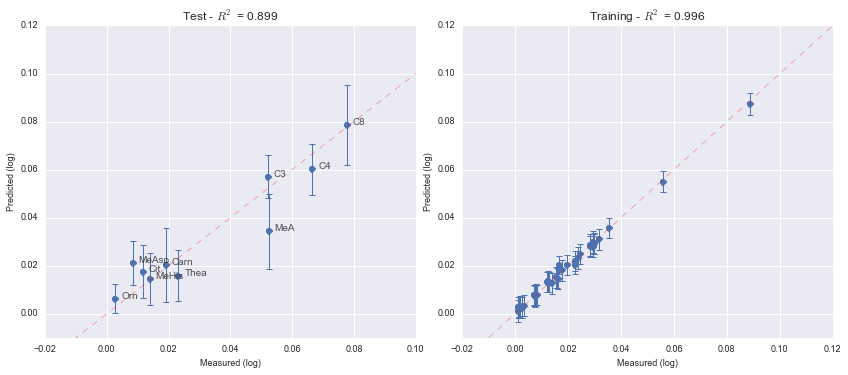

In [12]:
arr_nvar = [1e-5, 0.1, 1]
cv(arr_nvar, 'MinMaxTanimoto', 'gp_minmax')

# Tanimoto

,LogLikelihood
Param,
0.000008,21.210864
0.000129,20.317310
0.002154,14.660311
0.035938,5.283932
0.599484,-4.778989


7.74263682681e-06
Test Log-likelihood -1.6970634698
Training Log-likelihood 157.407110651


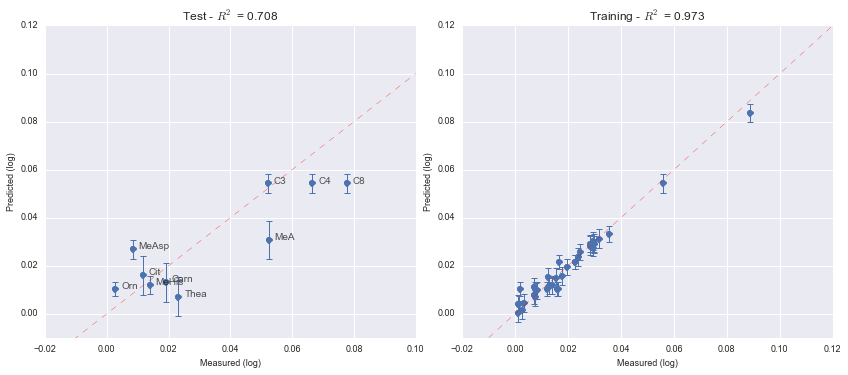

In [13]:
arr_nvar = np.logspace(-10, 1, num=10)
cv(arr_nvar, 'Tanimoto', 'gp_tanimoto')